In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_global_loss(dirlist):
    raw_loss_df = pd.DataFrame()
    H1_length_df = pd.DataFrame()
    H0_length_df = pd.DataFrame()
        
    for cur_dir in dirlist:
        raw_loss_df = raw_loss_df.append(pd.DataFrame.from_csv(os.path.join(cur_dir, "loss.csv")))
        H1_length_df = H1_length_df.append(pd.DataFrame.from_csv(os.path.join(cur_dir, "H1_length.csv")))
        H0_length_df = H0_length_df.append(pd.DataFrame.from_csv(os.path.join(cur_dir, "H0_length.csv")))
    
    discriminants = [col for col in raw_loss_df.columns if "campaign" not in col]
    length_df = H1_length_df[discriminants] + H0_length_df[discriminants]
    loss_df = raw_loss_df[discriminants]
    
    total_length_df = length_df.sum(axis = 1)
    global_loss_df = pd.DataFrame((length_df * loss_df).sum(axis = 1) / total_length_df)
    global_loss_df = pd.concat([raw_loss_df["campaign"], global_loss_df], axis = 1)
    global_loss_df.columns = ["campaign", "global loss"]
            
    return global_loss_df

In [3]:
def parse_campaign_name(string, keys):
    out_dict = {}
    
    for key in keys:
        start_pos = string.find(key) + len(key)
        end_pos = start_pos
        
        while end_pos < len(string) and not string[end_pos].isalpha() and not "/" in string[end_pos]:
            end_pos += 1
                                    
        out_dict[key] = float(string[start_pos + 1:end_pos])
        
    return out_dict

In [4]:
def convert_campaign_name(df, keys):
    augmented_frame = pd.DataFrame()

    for row in df.iterrows():
        row_dict = parse_campaign_name(row[1]["campaign"], keys)
        row_dict["global_loss"] = row[1]["global loss"]

        for key in row_dict.keys():
            row_dict[key] = [row_dict[key]]

        row_frame = pd.DataFrame.from_dict(row_dict)
        augmented_frame = pd.concat([augmented_frame, row_frame], axis = 0)
        
    return augmented_frame

In [5]:
def index_translation_dict(df, column):
    return {val: index for index, val in enumerate(list(set(df[column])))}

In [6]:
def convert_to_matshow(df, keys, plotcol):
    translations = []
    for key in keys:
        translations.append(index_translation_dict(df, key))
                
    plot_data = np.zeros((len(translations[0]), len(translations[1]))) 
        
    for index, row in df.iterrows():
        i = translations[0][row[keys[0]]]
        j = translations[1][row[keys[1]]]

        plot_data[i,j] = row[plotcol]
       
    return plot_data, np.array(translations[0].keys()), np.array(translations[1].keys())

In [46]:
gloss = compute_global_loss(["/data_CMS/cms/wind/HyperparameterPlots"])

In [47]:
cdf = convert_campaign_name(gloss, ["number_layers", "number_neurons"])

In [48]:
data, x_label, y_label = convert_to_matshow(cdf, ["number_layers", "number_neurons"], "global_loss")

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.transpose() / np.min(data), cmap = 'RdYlGn_r', vmin = 1.0, vmax = 1.032)
ax.set_xticklabels(np.concatenate([[''], x_label.astype(int) + 1]))
ax.set_yticklabels(np.concatenate([[''], y_label.astype(int)]))
#ax.xaxis.set_label_position("top")
ax.set_xlabel("hidden layers")
ax.set_ylabel("hidden neurons")

ax.set_title("validation loss")

fig.colorbar(cax, pad = 0.1)

# put the numeric values
for cur in np.ndenumerate(data):
    coords = cur[0]
    val = cur[1]
    ax.text(coords[0], coords[1], "{:4.4f}".format(val), va = 'center', ha = 'center', color = 'white', weight = 'bold')

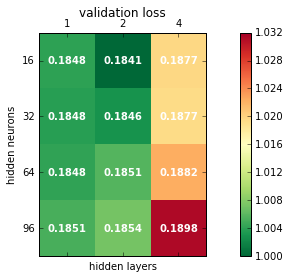

In [50]:
plt.show()